In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

In [3]:
data = pd.read_csv(r"C:\Users\DELL\Desktop\LSTM Data\LSTM Practice Model\NVDA.csv")
data = data["Close"]
#data = pd.DataFrame(data)
data = data[-10:].reset_index() ####### ####### ####### ######## ####### ####### 
data = data["Close"]
data

0    104.97
1    104.75
2    109.02
3    116.14
4    118.08
5    122.86
6    124.58
7    130.00
8    127.25
9    128.50
Name: Close, dtype: float64

## Single_Class Model

In [5]:
class TradingStrategy:
    def __init__(self, data):
        self.data = data
        
    ####################### ####################### ####################### ####################### ####################### ####################### ########
    def trail_function(self, sell_rate, buy_rate):
        
        # Variables for tracking orders and positions
        orders = []
        current_position = "Buy"
        
        # Initial conditions
        interval_max_price = self.data[0]
        stop_price_sell = interval_max_price * (1 - sell_rate)
        stop_price_buy = interval_max_price * (1 + buy_rate)
        
        # Trading loop
        for day_price in self.data:
            if current_position == "Buy":
                if day_price > interval_max_price:
                    interval_max_price = day_price
                    stop_price_sell = interval_max_price * (1 - sell_rate)

                elif day_price <= stop_price_sell:
                    orders.append(("Sell", day_price))
                    current_position = "Sell"
                    interval_max_price = day_price
                    stop_price_buy = interval_max_price * (1 + buy_rate)

            elif current_position == "Sell":
                if day_price < interval_max_price:
                    interval_max_price = day_price
                    stop_price_buy = interval_max_price * (1 + buy_rate)

                elif day_price >= stop_price_buy:
                    orders.append(("Buy", day_price))
                    current_position = "Buy"
                    interval_max_price = day_price
                    stop_price_sell = interval_max_price * (1 - sell_rate)
        return orders
        
    ####################### ####################### ####################### ####################### ####################### ####################### ########
    def calculate_total_profit(self, trade_dict):
        total_profit = 0
        initial_price = None

        for action, price in trade_dict:
            if action == 'Buy':
                initial_price = price
            elif action == 'Sell' and initial_price is not None:
                total_profit += (price / initial_price) - 1
                initial_price = price
        return total_profit
        
    ####################### ####################### ####################### ####################### ####################### ####################### ########
    def calculate_profit(self, trade_dict):
        transaction_returns = []
        initial_price = None

        for action, price in trade_dict:
            if action == 'Buy':
                initial_price = price
            elif action == 'Sell' and initial_price is not None:
                transaction_returns.append((price / initial_price) - 1)
                initial_price = price
        return transaction_returns
        
    ####################### ####################### ####################### ####################### ####################### ####################### ########
    def optimize_trading_rates(self, buy_rate_start=0.01):
        # Initialize variables
        returns = []
        sell_rate = []
        num_transactions = []
        Trading_Strategy = TradingStrategy(data)
        
        # Calculate returns and transactions for different sell rates
        for i in range(0, 100, 1):  # Using integers and dividing by 100
            i = i / 100.0
            sell_rate.append(i)
            returns.append(Trading_Strategy.calculate_total_profit(Trading_Strategy.trail_function(i, buy_rate_start)))
            num_transactions.append(len(Trading_Strategy.trail_function(i, buy_rate_start)))
    
        # Calculate transaction index for sell rates
        transaction_index = [
            (returns[j] / num_transactions[j]) if num_transactions[j] != 0 else 0 
            for j in range(len(sell_rate))
        ]
    
        # Find the optimized sell rate
        transaction_index_array = np.array(transaction_index)
        index = np.where(transaction_index_array == np.max(transaction_index_array))[0]
        optimized_sell_rate = sell_rate[index[0]]    
        
            # print(" ")
            # print(f" The Idex of transaction_index with the highest value:       {index}")
            # print(f" The transaction_index highest value:                        {transaction_index[index[0]]}")
            # print(f" The number of transactions made on the transaction_index:   {num_transactions[index[0]]}")
            # print(f" The Trail_Sell Rate used:                                   {sell_rate[index[0]]}")
        
        # Initialize variables for buy rate optimization
        returns_Buy = []
        buy_rate = []
        num_transactions_Buy = []
    
        # Calculate returns and transactions for different buy rates
        for i in range(0, 100, 1):  # Using integers and dividing by 100
            i = i / 100.0
            buy_rate.append(i)
            returns_Buy.append(Trading_Strategy.calculate_total_profit(Trading_Strategy.trail_function(optimized_sell_rate, i)))
            num_transactions_Buy.append(len(Trading_Strategy.trail_function(optimized_sell_rate, i)))
    
        # Calculate transaction index for buy rates
        transaction_index_Buy = [
            (returns_Buy[j] / num_transactions_Buy[j]) if num_transactions_Buy[j] != 0 else 0 
            for j in range(len(buy_rate))
        ]
    
        # Find the optimized buy rate
        transaction_index_array_Buy = np.array(transaction_index_Buy)
        index = np.where(transaction_index_array_Buy == np.max(transaction_index_array_Buy))[0]
        optimized_buy_rate = buy_rate[index[0]]

        total_optimized_return = Trading_Strategy.calculate_total_profit(Trading_Strategy.trail_function(optimized_sell_rate, optimized_buy_rate))
        num_transaction = len(Trading_Strategy.trail_function(optimized_sell_rate, optimized_buy_rate))
        
            # print(" ")
            # print(f" The Idex of transaction_index with the highest value:       {index}")
            # print(f" The transaction_index highest value:                        {transaction_index_Buy[index[0]]}")
            # print(f" The number of transactions made on the transaction_index:   {num_transactions_Buy[index[0]]}")
            # print(f" The Trail_Buy Rate used:                                    {buy_rate[index[0]]}")
    

        return {"optimized_sell_rate":optimized_sell_rate, 
                "optimized_buy_rate":optimized_buy_rate, 
                "returns":returns, 
                "returns_Buy":returns_Buy, 
                "num_transactions":num_transactions, 
                "num_transactions_Buy":num_transactions_Buy, 
                "transaction_index":transaction_index, 
                "transaction_index_Buy":transaction_index_Buy, 
                "total_optimized_return":total_optimized_return, 
                "num_transaction": num_transaction}

    ####################### ####################### ####################### ####################### ####################### ####################### ########
    def index_visualization(self):
        plt.figure(figsize=(10, 3))  # Adjust size if necessary
        
        # Plot returns on the left y-axis
        plt.plot(trading_strategy.optimize_trading_rates()["returns"], label='returns')
        plt.xlabel('Time')
        plt.ylabel('Returns')
        
        # Create a twin y-axis to plot num_transactions on the right y-axis
        ax2 = plt.twinx()
        ax2.plot(trading_strategy.optimize_trading_rates()["num_transactions"], color='orange', label='num_transactions')
        ax2.set_ylabel('Number of Transactions')
        
        # Add title and legends
        plt.title('Time Series Comparison')
        plt.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        # Show plot
        plt.show()
        
        plt.figure(figsize=(10, 3))  # Adjust size if necessary
        
        # Plot returns on the left y-axis
        plt.plot(trading_strategy.optimize_trading_rates()["returns"], label='returns')
        plt.xlabel('Time')
        plt.ylabel('Returns')
        
        # Create a twin y-axis to plot num_transactions on the right y-axis
        ax2 = plt.twinx()
        ax2.plot(trading_strategy.optimize_trading_rates()["transaction_index"], color='orange', label='transaction_index')
        ax2.set_ylabel('transaction_index')
        
        # Add title and legends
        plt.title('Time Series Comparison')
        plt.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        # Show plot
        plt.show()
        
        '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''' 
        
        plt.figure(figsize=(10, 3))  # Adjust size if necessary
        
        # Plot returns on the left y-axis
        plt.plot(trading_strategy.optimize_trading_rates()["returns_Buy"], label='returns')
        plt.xlabel('Time')
        plt.ylabel('Returns')
        
        # Create a twin y-axis to plot num_transactions on the right y-axis
        ax2 = plt.twinx()
        ax2.plot(trading_strategy.optimize_trading_rates()["num_transactions_Buy"], color='orange', label='num_transactions')
        ax2.set_ylabel('Number of Transactions')
        
        # Add title and legends
        plt.title('Time Series Comparison')
        plt.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        # Show plot
        plt.show()
        
        plt.figure(figsize=(10, 3))  # Adjust size if necessary
        
        # Plot returns on the left y-axis
        plt.plot(trading_strategy.optimize_trading_rates()["returns_Buy"], label='returns')
        plt.xlabel('Time')
        plt.ylabel('Returns')
        
        # Create a twin y-axis to plot num_transactions on the right y-axis
        ax2 = plt.twinx()
        ax2.plot(trading_strategy.optimize_trading_rates()["transaction_index_Buy"], color='orange', label='transaction_index')
        ax2.set_ylabel('transaction_index')
        
        # Add title and legends
        plt.title('Time Series Comparison')
        plt.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        # Show plot
        plt.show()

    ####################### ####################### ####################### ####################### ####################### ####################### ########
    def transactions_visualization(self, MA_Window=5): 
        trading_strategy = TradingStrategy(data)
        transactions = trading_strategy.trail_function(trading_strategy.optimize_trading_rates()["optimized_sell_rate"], trading_strategy.optimize_trading_rates()["optimized_buy_rate"])
        
        # Calculate the moving average with a window of 5
        moving_average = data.rolling(window=MA_Window).mean()
        
        # Find the indices of the transaction prices in the time series
        buy_indices = []
        sell_indices = []
        buy_prices = []
        sell_prices = []
        
        for transaction in transactions:
            transaction_type, transaction_price = transaction
            # Find the closest index for each transaction price
            index = (np.abs(data - transaction_price)).idxmin() 
                                                                 
            if transaction_type.lower() == 'buy':
                buy_indices.append(index)
                buy_prices.append(data[index])
            elif transaction_type.lower() == 'sell':
                sell_indices.append(index)
                sell_prices.append(data[index])
        
        # Plot the time series
        plt.figure(figsize=(17, 10))
        plt.plot(data, label='Price', color='blue')
        
        # Plot the moving average
        plt.plot(moving_average, label='Moving Average (Window=5)', color='orange')
        
        # Plot buy signals
        plt.scatter(buy_indices, buy_prices, marker='^', color='green', s=100, label='Buy Signal')
        
        # Plot sell signals
        plt.scatter(sell_indices, sell_prices, marker='v', color='red', s=100, label='Sell Signal')
        
        # Add labels and title
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.title('Time Series with Buy and Sell Signals')
        plt.legend()
        
        # Show plot
        plt.show()

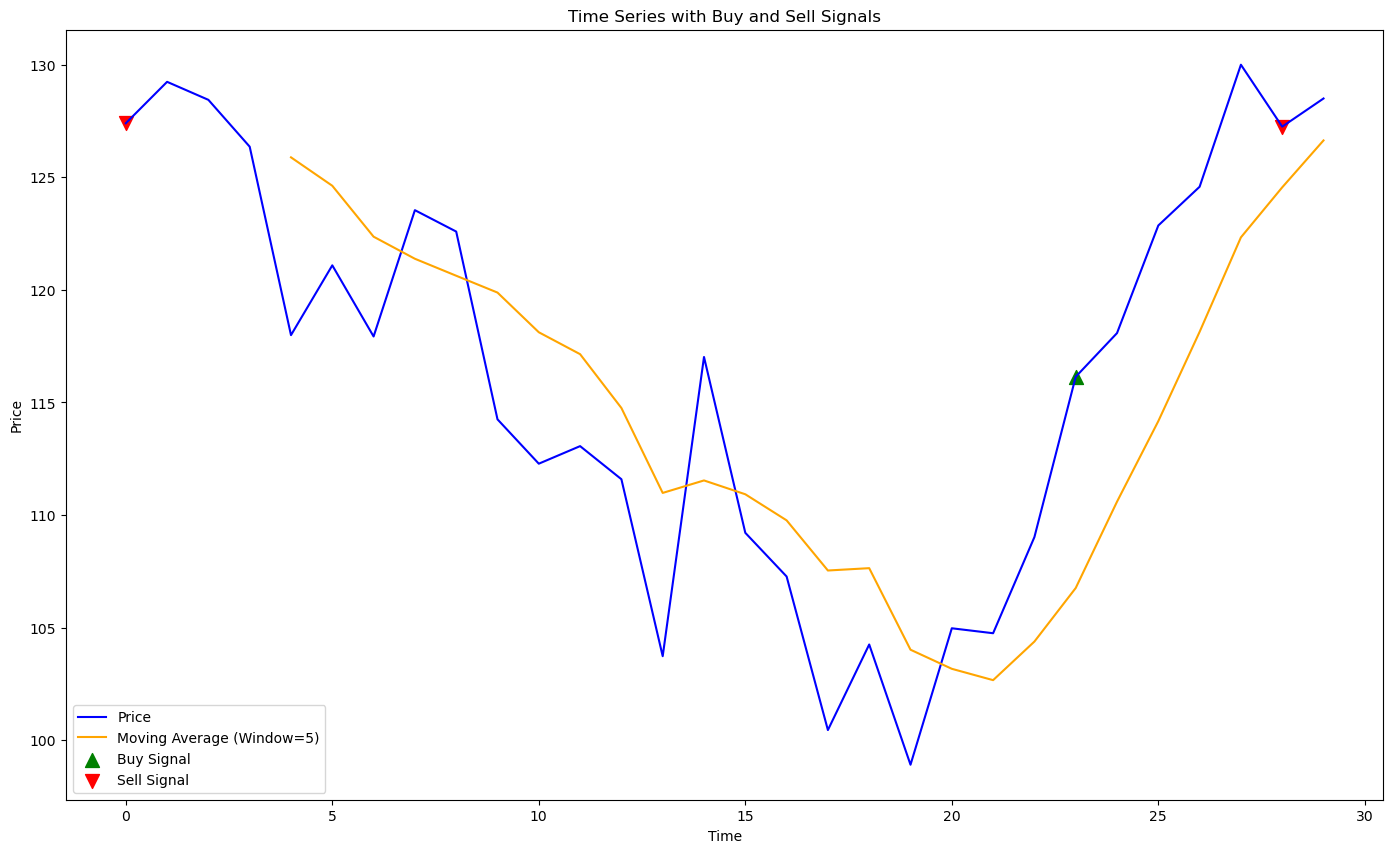

In [14]:
trading_strategy = TradingStrategy(data)
#trading_strategy.optimize_trading_rates()["transaction_index_Buy"]
trading_strategy.transactions_visualization()

## Full Optimization

In [ ]:
# Starting Grownds
transaction_index_ls = []
moving_window_size = []

for i in range(6, 7):
    # Determine the batch size
    moving_window = i
    transaction_index_batch_ls = []
    
    # Split the data into batches of 20 entries
    batches = [data[i:i + moving_window] for i in range(0, len(data), moving_window)]

    # Reset index for each batch
    batches = [batch.reset_index(drop=True) for batch in batches]
    
    # Access each batch
    for batch in batches:
        trading_strategy = TradingStrategy(batch)

        returns = trading_strategy.calculate_total_profit(trading_strategy.trail_function(trading_strategy.optimize_trading_rates()["optimized_sell_rate"]), 
                                                          trading_strategy.trail_function(trading_strategy.optimize_trading_rates()["optimized_buy_rate"]))
        
        #returns = trading_strategy.optimize_trading_rates()["total_optimized_return"]
        num_transactions = trading_strategy.optimize_trading_rates()["num_transaction"]

        transaction_index_batch_ls.append(returns / num_transactions) #+= (returns / num_transaction)

    transaction_index_ls.append(np.mean(transaction_index_batch_ls))
    moving_window_size.append(moving_window)
    
transaction_index_ls

The Problem may be at the creation of the variables of the total_optimized_return since calculating the return needs the optimize_trading_rates-method to run

    total_optimized_return = Trading_Strategy.calculate_total_profit(Trading_Strategy.trail_function(optimized_sell_rate, optimized_buy_rate))
    num_transaction = len(Trading_Strategy.trail_function(optimized_sell_rate, optimized_buy_rate))

In [80]:
trading_strategy = TradingStrategy(data)

trading_strategy.trail_function(trading_strategy.optimize_trading_rates()["optimized_sell_rate"], 
                                trading_strategy.optimize_trading_rates()["optimized_buy_rate"])

[('Sell', 76.2), ('Buy', 87.74), ('Sell', 114.25), ('Buy', 116.14)]

In [90]:
print(batches[2])
test_strategy = TradingStrategy(batches[2])
print(test_strategy.optimize_trading_rates()["total_optimized_return"])
print(test_strategy.optimize_trading_rates()["total_optimized_return"])

#test_strategy.trail_function(0.01,0.01) 
# test_strategy.optimize_trading_rates()["optimized_sell_rate"]
# test_strategy.optimize_trading_rates()["optimized_buy_rate"]

0    84.04
1    84.67
2    76.20
3    79.52
4    82.42
5    79.68
Name: Close, dtype: float64
0.30214269432413965


[('Sell', 76.2), ('Buy', 79.52), ('Sell', 79.68)]

When trying to run the model on a particular batch it runns instead on the whole data 

In [7]:
#print(batches[2])

test2_strategy = TradingStrategy(data)
print(test2_strategy.optimize_trading_rates()["total_optimized_return"])
print(test2_strategy.optimize_trading_rates()["num_transactions"])

#test2_strategy.calculate_total_profit(test2_strategy.trail_function(0.01, 0.01))
#test2_strategy.trail_function(0.01, 0.01)

test2_strategy.trail_function(test2_strategy.optimize_trading_rates()["optimized_sell_rate"], 
                                test2_strategy.optimize_trading_rates()["optimized_buy_rate"])

# test2_strategy.optimize_trading_rates()["optimized_sell_rate"]
# test2_strategy.optimize_trading_rates()["optimized_buy_rate"]

0.16721702439919284
[3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


0.0

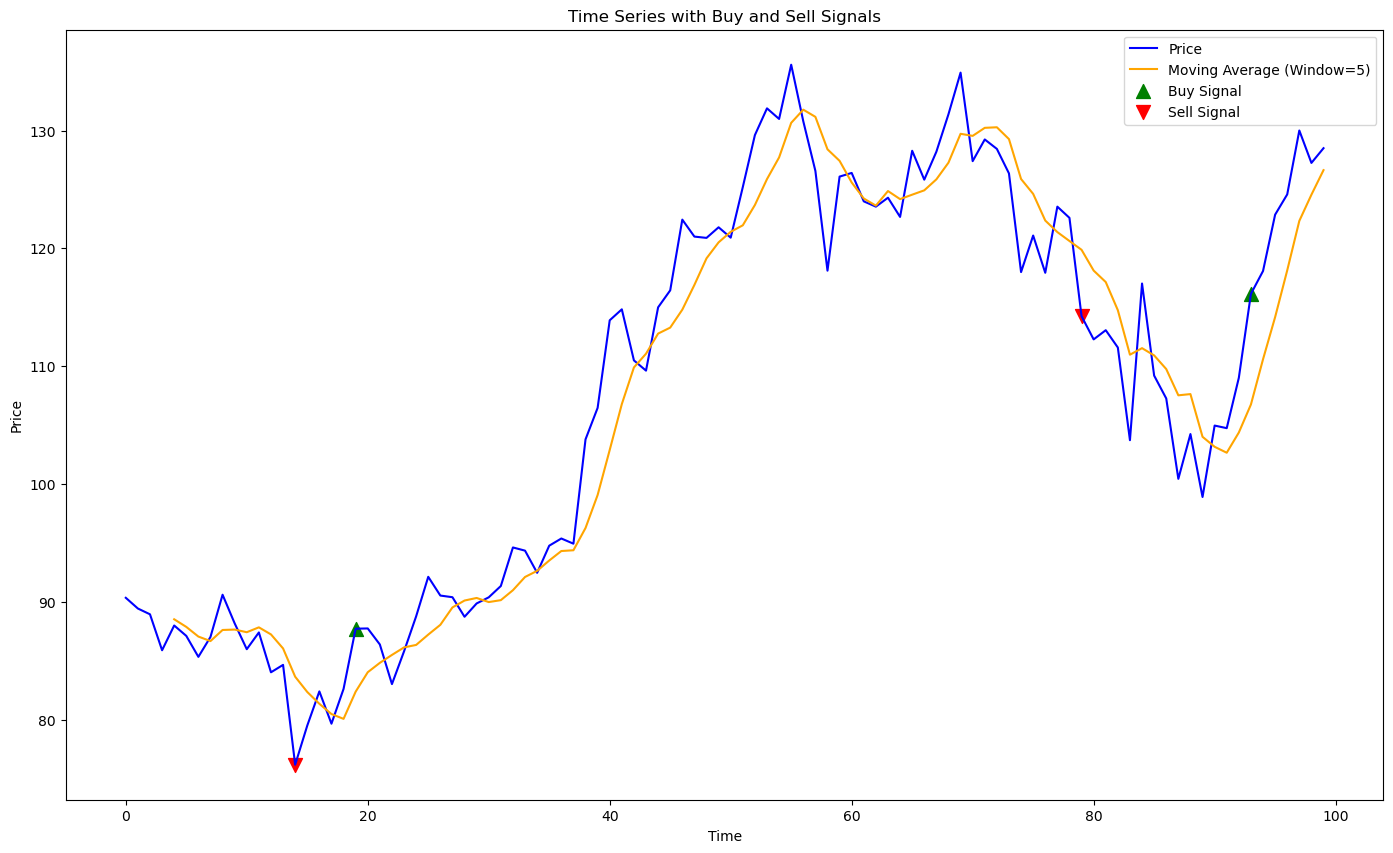

In [137]:
test2_strategy.transactions_visualization()

In [39]:
transaction_index_ls


[0.3188680328339359,
 0.2550944262671487,
 0.1913208197003615,
 0.15943401641696792,
 0.15943401641696792,
 0.12754721313357434,
 0.12754721313357434,
 0.09566040985018076,
 0.09566040985018076,
 0.09566040985018076,
 0.09566040985018076,
 0.09566040985018076,
 0.06377360656678717,
 0.06377360656678717,
 0.06377360656678717,
 0.06377360656678717,
 0.06377360656678717,
 0.06377360656678717,
 0.06377360656678717,
 0.06377360656678717,
 0.06377360656678717,
 0.06377360656678717,
 0.06377360656678717,
 0.06377360656678717,
 0.06377360656678717,
 0.06377360656678717,
 0.06377360656678717,
 0.031886803283393585,
 0.031886803283393585,
 0.031886803283393585]

In [32]:
# chat GPT optimized code

transaction_index_ls = []
moving_window_size = []

for window_size in range(3, 33):
    # Determine the moving window size
    moving_window = window_size
    transaction_index = 0
    
    # Split the data into batches of size equal to moving_window
    batches = [data[j:j + moving_window] for j in range(0, len(data), moving_window)]
    
    # Process each batch
    for batch in batches:
        trading_strategy = TradingStrategy(batch)
        
        # Optimize trading rates once and store the result
        optimized_result = trading_strategy.optimize_trading_rates()
        optimized_sell_rate = optimized_result["optimized_sell_rate"]
        optimized_buy_rate = optimized_result["optimized_buy_rate"]
        returns = optimized_result["total_optimized_return"]
        
        # Calculate the number of transactions
        num_transaction = len(trading_strategy.trail_function(optimized_sell_rate, optimized_buy_rate))
        
        # Calculate transaction index, handling division by zero
        if num_transaction != 0:
            transaction_index += (returns / num_transaction)
    
    # Store the results for each window size
    transaction_index_ls.append(transaction_index)
    moving_window_size.append(moving_window)


KeyError: 0

In [31]:
trading_strategy = TradingStrategy(data)

num_transaction = len(trading_strategy.trail_function(trading_strategy.optimize_trading_rates()["optimized_sell_rate"], 
                                                      trading_strategy.optimize_trading_rates()["optimized_buy_rate"]))
num_transaction                      

3

In [21]:
trading_strategy = TradingStrategy(data)
#sum(trading_strategy.optimize_trading_rates()["returns"])
trading_strategy.optimize_trading_rates()["num_transactions"]

[15,
 11,
 11,
 8,
 8,
 8,
 6,
 6,
 6,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
# Loop through the data in intervals of 20
moving_window = 20

for i in range(0, len(data), moving_window):
    batch = data[i:i+moving_window]
    trading_strategy = TradingStrategy(batch)
    trading_strategy.optimize_trading_rates()